In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import datetime
import re
from elasticsearch import Elasticsearch, exceptions as es_exceptions
from elasticsearch.helpers import scan
es = Elasticsearch(hosts=[{'host':'atlas-kibana.mwt2.org', 'port':9200}],timeout=60)

In [2]:
indices = es.cat.indices(index="jobs_archive_*", h="index", request_timeout=600).split('\n')
indices = sorted(indices)
indices = [x for x in indices if x != '']
print(indices)

['jobs_archive_2016-01-01', 'jobs_archive_2016-01-02', 'jobs_archive_2016-01-03', 'jobs_archive_2016-01-04', 'jobs_archive_2016-01-05', 'jobs_archive_2016-01-06', 'jobs_archive_2016-01-07', 'jobs_archive_2016-01-08', 'jobs_archive_2016-01-09', 'jobs_archive_2016-01-10', 'jobs_archive_2016-01-11', 'jobs_archive_2016-01-12', 'jobs_archive_2016-01-13', 'jobs_archive_2016-01-14', 'jobs_archive_2016-01-15', 'jobs_archive_2016-01-16', 'jobs_archive_2016-01-17', 'jobs_archive_2016-01-18', 'jobs_archive_2016-01-19', 'jobs_archive_2016-01-20', 'jobs_archive_2016-01-21', 'jobs_archive_2016-01-22', 'jobs_archive_2016-01-23', 'jobs_archive_2016-01-24', 'jobs_archive_2016-01-25', 'jobs_archive_2016-01-26', 'jobs_archive_2016-01-27', 'jobs_archive_2016-01-28', 'jobs_archive_2016-01-29', 'jobs_archive_2016-01-30', 'jobs_archive_2016-01-31', 'jobs_archive_2016-02-01', 'jobs_archive_2016-02-02', 'jobs_archive_2016-02-03', 'jobs_archive_2016-02-04', 'jobs_archive_2016-02-05', 'jobs_archive_2016-02-06', 

In [3]:
def time_filter(indices, last_days=1, pattern=''):
    if last_days == 0:
        return ["jobs_archive_*"]
    filtered = []
    if pattern:
        for i in indices:
            if pattern in i:
                filtered.append(i.rstrip())
        return filtered
    today = datetime.date.today()
    filtered = []
    datefmt = '%Y-%m-%d'
    for i in indices:
        day = re.sub(r'jobs_archive_', '', i).rstrip()
        day = datetime.datetime.strptime(day, datefmt).date()
        diff = today - day
        if diff.days <= last_days:
            filtered.append(i.rstrip())
    return filtered

In [4]:
ind = time_filter(indices, 7, "" )
ind = ','.join(ind)
print(ind)

jobs_archive_2017-07-10,jobs_archive_2017-07-11,jobs_archive_2017-07-12,jobs_archive_2017-07-13,jobs_archive_2017-07-14,jobs_archive_2017-07-15,jobs_archive_2017-07-16,jobs_archive_2017-07-17


In [5]:
#q = "NOT produsername:gangarbt AND jobstatus:finished AND processingtype:reprocessing AND proddblock:*.00283429.*"
#q = "NOT produsername:gangarbt AND jobstatus:finished AND processingtype:pile"
q = "NOT produsername:gangarbt AND jobstatus:finished AND NOT transformation:*pandaserver* AND pilotid:*68.0* AND processingtype:reprocessing"

In [6]:
myquery = {
  "query": {
    "filtered": {
      "query": {
        "query_string": {
          "query": "NOT produsername:gangarbt",
          "analyze_wildcard": True,
          "lowercase_expanded_terms": False
        }
      },
      "filter": {
        "bool": {
          "must": [
            {
              "query": {
                "match": {
                  "processingtype": {
                    "query": "pile",
                    "type": "phrase"
                  }
                }
              }
            },
            {
              "query": {
                "match": {
                  "jobstatus": {
                    "query": "finished",
                    "type": "phrase"
                  }
                }
              }
            },
                     ]
        }
      }
    }
  },
  "size": 0,
  "aggs": {
    "2": {
      "histogram": {
        "script": "(doc['nevents'].value) ? doc['wall_time'].value*10/doc['nevents'].value : 0",
        "lang": "expression",
        "interval": 5
      },
      "aggs": {
        "3": {
          "significant_terms": {
            "field": "computingsite",
            "size": 10
          }
        }
      }
    }
  }
}


myqueryPile = {
  "query": {
    "bool": {
      "must": [
        {
          "query_string": {
            "query": "NOT produsername:gangarbt AND NOT processingtype:*panda-client* AND NOT processingtype:*jedi*",
            "analyze_wildcard": True,
            "lowercase_expanded_terms": False
          }
        },
        {
          "match": {
            "jobstatus": {
              "query": "finished",
              "type": "phrase"
            }
          }
        },
        {
          "match": {
            "processingtype": {
              "query": "pile",
              "type": "phrase"
            }
          }
        },
      ],
      "must_not": []
    }
  },
      "aggs": {
        "2": {
          "histogram": {
                        "script": {
          "inline": "doc['IOcharReadRate'].value/1048576.",
          "lang": "expression"
        },
            "interval": 0.1,
            "min_doc_count": 1
          },
          "aggs": {
            "3": {
              "significant_terms": {
                "field": "homepackage",
                "size": 20
              }
            }
          }
        }
      }

  }


myqueryPile2 = {
  "query": {
    "bool": {
      "must": [
        {
          "query_string": {
            "query": "NOT produsername:gangarbt AND NOT processingtype:*panda-client* AND NOT processingtype:*jedi*",
            "analyze_wildcard": True,
            "lowercase_expanded_terms": False
          }
        },
        {
          "match": {
            "jobstatus": {
              "query": "finished",
              "type": "phrase"
            }
          }
        },
        {
          "match": {
            "processingtype": {
              "query": "pile",
              "type": "phrase"
            }
          }
        },
      ],
      "must_not": []
    }
  },
      "aggs": {
        "2": {
                  "histogram": {
        "script": {
          "inline": "doc['IOcharRead'].value/1048576.",
          "lang": "expression"
        },
        "interval": 1,
            "min_doc_count": 1
          },
          "aggs": {
            "3": {
              "significant_terms": {
                "field": "homepackage",
                "size": 20
              }
            }
          }
        }
      }

  }

myqueryPile3 = {
  "query": {
    "bool": {
      "must": [
        {
          "query_string": {
            "query": "NOT produsername:gangarbt AND NOT processingtype:*panda-client* AND NOT processingtype:*jedi*",
            "analyze_wildcard": True,
            "lowercase_expanded_terms": False
          }
        },
        {
          "match": {
            "jobstatus": {
              "query": "finished",
              "type": "phrase"
            }
          }
        },
        {
          "match": {
            "processingtype": {
              "query": "pile",
              "type": "phrase"
            }
          }
        },
      ],
      "must_not": []
    }
  },
      "aggs": {
        "2": {
                  "histogram": {
        "script": {
          "inline": "doc['inputfilebytes'].value/1073741824.",
          "lang": "expression"
        },
        "interval": 0.5,
            "min_doc_count": 1
          },
          "aggs": {
            "3": {
              "significant_terms": {
                "field": "homepackage",
                "size": 20
              }
            }
          }
        }
      }

  }

myqueryWalltime = {
  "query": {
    "bool": {
      "must": [
        {
          "query_string": {
            "query": "NOT produsername:gangarbt AND jobstatus:finished AND NOT transformation:*pandaserver* AND pilotid:*68.0* AND processingtype:reprocessing AND inputfiletype:RAW",
            "analyze_wildcard": True,
            "lowercase_expanded_terms": False
          }
        },
      ],
      "must_not": []
    }
  },
  "aggs": {
    "2": {
      "histogram": {
        "script": {
          "inline": "(doc['nevents'].value && doc['actualcorecount'].value) ? doc['wall_time'].value*doc['actualcorecount'].value/doc['nevents'].value : 0",
          "lang": "expression"
        },
        "interval": 0.5,
        "min_doc_count": 1
      },
      "aggs": {
        "3": {
          "significant_terms": {
            "field": "computingsite",
            "size": 20
          }
        }
      }
    }
  }
}

myqueryWalltime2 = {
  "query": {
    "bool": {
      "must": [
        {
          "query_string": {
            "query": "jobstatus:finished AND pilotid:*68* AND processingtype:reprocessing AND inputfiletype:RAW",
            "analyze_wildcard": True,
            "lowercase_expanded_terms": False
          }
        },
      ],
      "must_not": []
    }
  },
  "aggs": {
    "2": {
      "histogram": {
        "script": {
          "inline": "(doc['nevents'].value && doc['actualcorecount'].value) ? doc['wall_time'].value*doc['actualcorecount'].value/doc['nevents'].value : 0",
          "lang": "expression"
        },
        "interval": 1,
        "min_doc_count": 1
      },
      "aggs": {
        "3": {
          "significant_terms": {
            "field": "computingsite",
            "size": 1000
          }
        }
      }
    }
  }
}

myqueryWalltime3 = {
  "query": {
    "bool": {
      "must": [
        {
          "query_string": {
            "query": "NOT produsername:gangarbt AND jobstatus:finished AND NOT transformation:*pandaserver* AND pilotid:*68* AND processingtype:reprocessing AND inputfiletype:RAW",
            "analyze_wildcard": True,
            "lowercase_expanded_terms": False
          }
        },
      ],
      "must_not": []
    }
  },
  "aggs": {
    "2": {
      "histogram": {
        "script": {
          "inline": "(doc['nevents'].value && doc['actualcorecount'].value) ? doc['wall_time'].value*doc['actualcorecount'].value/doc['nevents'].value : 0",
          "lang": "expression"
        },
        "interval": 1,
        "min_doc_count": 1
      }
    }
  }
}





In [7]:
res = es.search(index=ind, body=myqueryWalltime2, request_timeout=600)

In [8]:
print(res)

{'timed_out': False, '_shards': {'total': 40, 'failed': 0, 'successful': 40}, 'aggregations': {'2': {'buckets': [{'doc_count': 1, 'key': 13.0, '3': {'doc_count': 1, 'buckets': []}}, {'doc_count': 2, 'key': 14.0, '3': {'doc_count': 2, 'buckets': []}}, {'doc_count': 3, 'key': 15.0, '3': {'doc_count': 3, 'buckets': [{'doc_count': 3, 'key': 'SARA-MATRIX_MCORE', 'score': 744.5063829787234, 'bg_count': 1410}]}}, {'doc_count': 4, 'key': 16.0, '3': {'doc_count': 4, 'buckets': [{'doc_count': 3, 'key': 'DESY-ZN_MCORE', 'score': 1338.3945135746606, 'bg_count': 442}]}}, {'doc_count': 3, 'key': 17.0, '3': {'doc_count': 3, 'buckets': [{'doc_count': 3, 'key': 'DESY-ZN_MCORE', 'score': 2305.3377192982457, 'bg_count': 456}]}}, {'doc_count': 14, 'key': 18.0, '3': {'doc_count': 14, 'buckets': [{'doc_count': 14, 'key': 'DESY-ZN_MCORE', 'score': 2301.029772329247, 'bg_count': 1142}]}}, {'doc_count': 9, 'key': 19.0, '3': {'doc_count': 9, 'buckets': [{'doc_count': 9, 'key': 'DESY-ZN_MCORE', 'score': 2297.885

2.0 5 10
1 0
5 5
SARA-MATRIX_MCORE 5
DESY-ZN_MCORE 5
CA-MCGILL-CLUMEQ-T2_MCORE 5
IN2P3-CC_MCORE_HIMEM 5
INFN-T1_MCORE 5


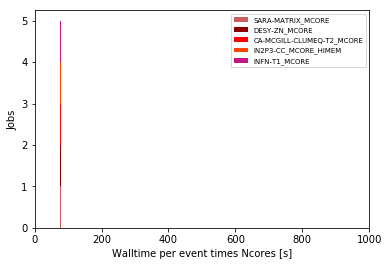

In [9]:
hists = []
xbins = []
rels = []

#hists =[[]]
#rels = ['All sites']

# First loop: determine AtlasRelease numbers and initialize histograms
for r in res['aggregations']['2']['buckets']:
    for e in r['3']['buckets']:
        if not e['key'] in rels:
            rels.append(e['key'])
            hists.append([])

# Now loop again and fill the histogram bins            
xbin = 0
for r in res['aggregations']['2']['buckets']:
    x = r['key']
    #print(x)
    #print(r['doc_count'])
    #if x>199: # This is the x-axis cut for inputfilebytes !
    #if x>199: # This is the x-axis cut for total !
    #if x>17.9: # This is the x-axis cut for rate !
    if (x<60 or x>240):
        continue
    xbins.append(x)
    for hist in hists:
        hist.append(r['doc_count'])
    for e in r['3']['buckets']:
        #print(e)
        for rel, hist in zip(rels,hists):
            if e['key'] == rel:
                hist[xbin] = e['doc_count']       
    xbin = xbin + 1

#print(hists)

allsites = hists[0]
ibin = 0
sum = 0
wsum = 0
max = 0
for bin in allsites:
    if bin > max:
        max = bin
        maxbin = ibin
    sum = sum + bin
    wsum = wsum + bin * ibin
    ibin = ibin +1

mean = wsum/sum
print (mean, sum, wsum)
print (max, maxbin)
print(len(xbins),len(hists))

# Initialisation for histogram stacking
y_offset = np.array([0.0] * len(xbins))
#colors = plt.cm.BuPu(np.linspace(0, 0.5, len(hists)))
#allcolors = ('#ff3333', '#33ff33', '#3333ff', '#33ffff', "#ffffff", '#000000', '#ff0000', '#00ff00', '#0000ff')
#allcolors = ('accent', 'dark2', 'paired', 'pastel1','pastel2', 'set1', 'set2', 'set3', 'vega10','vega20', 'vega20b', 'vega20c')
#allcolors = [u'#4B0082', u'#FFD700', u'#FF69B4', u'#B22222', u'#CD5C5C', u'#87AE73', u'#FFFF00', u'#FFE4E1', u'#556B2F', u'#808000', u'#8FBC8F', u'#FFC0CB', u'#FF6347', u'#F08080', u'#FF4500', u'#FFDEAD', u'#00FF00', u'#98FB98', u'#2F4F4F', u'#ADFF2F', u'#DEB887', u'#FFF5EE', u'#00FA9A', u'#FF00FF', u'#FFEFD5', u'#FFEBCD', u'#7FFF00', u'#696969', u'#000000', u'#FFDAB9', u'#00FF7F', u'#7FFFD4', u'#FFFFFF', u'#FFA500', u'#FFA07A', u'#2F4F4F', u'#A52A2A', u'#FFFFF0', u'#1E90FF', u'#CD853F', u'#A9A9A9', u'#7CFC00', u'#D2691E', u'#DC143C', u'#228B22', u'#6A5ACD', u'#20B2AA', u'#00FFFF', u'#F5FFFA', u'#C0C0C0', u'#FAEBD7', u'#BA55D3', u'#87CEEB', u'#808080', u'#00CED1', u'#DAA520', u'#006400', u'#FFFAF0', u'#9400D3', u'#A9A9A9', u'#FFE4B5', u'#8B4513', u'#808080', u'#483D8B', u'#87CEFA', u'#FFB6C1', u'#C71585', u'#708090', u'#FF0000', u'#FF1493', u'#32CD32', u'#8B008B', u'#EEE8AA', u'#DDA0DD', u'#40E0D0', u'#D3D3D3', u'#FAFAD2', u'#B8860B', u'#E6E6FA', u'#800000', u'#9ACD32', u'#FAA460', u'#D8BFD8', u'#EE82EE', u'#000080', u'#FF00FF', u'#696969', u'#D2B48C', u'#BC8F8F', u'#6B8E23', u'#0000FF', u'#ADD8E6', u'#F8F8FF', u'#F0FFF0', u'#6495ED', u'#FAF0E6', u'#00008B', u'#B0E0E6', u'#2E8B57', u'#BDB76B', u'#FFFAFA', u'#A0522D', u'#0000CD', u'#4169E1', u'#E0FFFF', u'#008000', u'#9370DB', u'#191970', u'#FFF8DC', u'#AFEEEE', u'#FFE4C4', u'#708090', u'#008B8B', u'#F0E68C', u'#F5DEB3', u'#008080', u'#9932CC', u'#00BFFF', u'#FA8072', u'#8B0000', u'#4682B4', u'#DB7093', u'#778899', u'#F0F8FF', u'#778899', u'#90EE90', u'#DA70D6', u'#DCDCDC', u'#3CB371', u'#D3D3D3', u'#48D1CC', u'#598556', u'#FFFACD', u'#5F9EA0', u'#FFFFE0', u'#FFF0F5', u'#FF7F50', u'#800080', u'#00FFFF', u'#BCECAC', u'#F5F5F5', u'#7B68EE', u'#FF8C00', u'#66CDAA', u'#E9967A', u'#F5F5DC', u'#8A2BE2', u'#F0FFFF', u'#B0C4DE', u'#FDF5E6']
allcolors = [u'#CD5C5C', u'#8B0000', u'#FF0000', u'#FF4500', u'#C71585', u'#DB7093',u'#5F9EA0', u'#B0E0E6', u'#ADD8E6', u'#00BFFF', u'#87CEEB', u'#87CEFA', u'#4682B4', u'#F0F8FF', u'#1E90FF', u'#B0C4DE', u'#6495ED', u'#4169E1', u'#191970', u'#00008B', u'#0000CD', u'#0000FF', u'#6A5ACD', u'#483D8B', u'#7B68EE', u'#8A2BE2',u'#9ACD32', u'#556B2F', u'#ADFF2F', u'#7CFC00', u'#8FBC8F', u'#98FB98', u'#90EE90', u'#228B22', u'#32CD32', u'#006400', u'#008000', u'#2E8B57', u'#3CB371', u'#00FF7F', u'#00FA9A', u'#20B2AA']

#from itertools import cycle, islice
#allcolors = list(islice(cycle(['b', 'r', 'g', 'c', 'm', 'y', 'k', 'w']), None, len(hists)))

colors = allcolors[:len(hists)]
#print(colors)

for hist, rel, icolor in zip(hists,rels, colors):
    sum = 0
    for i in hist:
        sum = sum + i
    print (rel, sum )
    
for hist, rel, icolor in zip(hists, rels, colors):
    #print(hist,xbins)
    #plt.plot(xbins,hist)
    plt.bar(xbins, hist, bottom=y_offset, log=False, label=rel, color=icolor, width=1)
    #plt.bar(xbins, hist, log=False, label=rel, color=icolor, width=10)
    y_offset = y_offset + hist
    #print(hist)
    #plt.hist(hist,bins=xbins, log=True, label=rels[i])
    plt.xlabel('Walltime per event times Ncores [s]')
    plt.ylabel('Jobs')

plt.legend(loc='upper right',prop={'size':7})
plt.xlim([0,1000])
#plt.text(200, 8000, r'$\mu=%2.1f s,\ max=%s s$'%(mean, maxbin))

plt.savefig("walltimes.png")
plt.show()

